In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# General dependencies
import os
import random
import pathlib
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Obtain the paths to the training and the test sets
training_set_path = "/content/drive/MyDrive/Project_4/calc_train"
test_set_path = "/content/drive/MyDrive/Project_4/calc_test"
efn_net_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [4]:
# Get the class names programmetically
data_dir = pathlib.Path(training_set_path)
# Created a list of class_names from the sub-directories
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
#class_names = class_names[1:]
print(class_names)

['BENIGN' 'BENIGN_WITHOUT_CALLBACK' 'MALIGNANT']


In [5]:
# Walk through a directory
for dirpath, dirnames, filenames in os.walk(training_set_path):
    print(f"{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

3 directories and 0 images in '/content/drive/MyDrive/Project_4/calc_train'.
0 directories and 262 images in '/content/drive/MyDrive/Project_4/calc_train/BENIGN'.
0 directories and 272 images in '/content/drive/MyDrive/Project_4/calc_train/MALIGNANT'.
0 directories and 192 images in '/content/drive/MyDrive/Project_4/calc_train/BENIGN_WITHOUT_CALLBACK'.


In [6]:
# Visualize random signal-set
def getANDview_random_img(target_dir, target_class):
  # Setup the target directory (we will view images from here)
  target_folder = target_dir + target_class
  # Get a random img file path
  random_img_name = random.sample(os.listdir(target_folder),1) # this will output as a list
  print(random_img_name)
  # Read the image the plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_img_name[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Img Shape: {img.shape}")
  return img

['1-257.jpg']
Img Shape: (5056, 2806)
Current img shape = (5056, 2806)


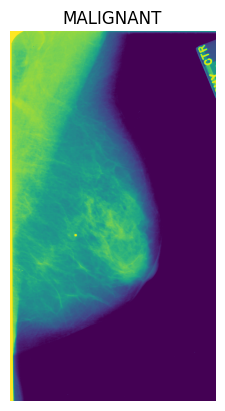

In [16]:
# Test the getANDview_random_img
curr_img = getANDview_random_img(target_dir = training_set_path + "/", target_class = "MALIGNANT")
rows, cols = curr_img.shape
print(f"Current img shape = {curr_img.shape}")

In [11]:
tf.constant(curr_img)

<tf.Tensor: shape=(4681, 1936), dtype=uint8, numpy=
array([[249, 249, 254, ...,   0,   0,   0],
       [250, 250, 255, ...,   0,   0,   0],
       [250, 250, 255, ...,   0,   0,   0],
       ...,
       [249, 249, 255, ...,   0,   0,   0],
       [249, 249, 254, ...,   0,   0,   0],
       [249, 249, 255, ...,   0,   0,   0]], dtype=uint8)>

In [13]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    training_set_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    training_set_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed = 42
)

test_generator = datagen.flow_from_directory(
    test_set_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed = 42
)

Found 582 images belonging to 3 classes.
Found 144 images belonging to 3 classes.
Found 271 images belonging to 3 classes.


In [10]:
# install the EfficientNet package
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [14]:
# import efficientnet.tfkeras as efn
# from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Define a model from the model url
def create_model(model_url, num_classes = 3):
    ftr_extr_layer = hub.KerasLayer(model_url,
                                    trainable = False,
                                    input_shape = IMG_SIZE)
    model = Sequential([
        ftr_extr_layer,
        # GlobalAveragePooling2D(),
        Dense(3, activation='softmax')  # 3 classes: BENIGN, MALIGNANT, BENIGN_NO_CALL
    ])
    return model

# base_model = efn.EfficientNetB7(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
# base_model = Xception(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
# base_model.trainable = False  # Freeze layers

# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(3, activation='softmax')  # 3 classes: BENIGN, MALIGNANT, BENIGN_NO_CALL
# ])

model = create_model(efn_net_url, num_classes = 3)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

TypeError: ignored

In [ ]:
model.summary()

In [26]:
history = model.fit(
    train_generator,
    # steps_per_epoch = len(train_generator), #.samples // BATCH_SIZE,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,

    validation_data = validation_generator,
    # validation_steps = len(validation_generator), #.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,

    epochs=50
)

Epoch 1/50
18/18 [==============================] - 92s 5s/step - loss: 1.0827 - accuracy: 0.4218 - val_loss: 1.0677 - val_accuracy: 0.3906
Epoch 2/50
18/18 [==============================] - 79s 4s/step - loss: 1.0268 - accuracy: 0.4545 - val_loss: 1.0232 - val_accuracy: 0.4844
Epoch 3/50
18/18 [==============================] - 77s 4s/step - loss: 0.9552 - accuracy: 0.5309 - val_loss: 1.0266 - val_accuracy: 0.4766
Epoch 4/50
18/18 [==============================] - 83s 5s/step - loss: 0.9502 - accuracy: 0.5255 - val_loss: 1.0400 - val_accuracy: 0.4375
Epoch 5/50
18/18 [==============================] - 78s 4s/step - loss: 0.9240 - accuracy: 0.5382 - val_loss: 0.9935 - val_accuracy: 0.4766
Epoch 6/50
18/18 [==============================] - 80s 5s/step - loss: 0.9165 - accuracy: 0.5255 - val_loss: 1.0289 - val_accuracy: 0.4297
Epoch 7/50
18/18 [==============================] - 82s 5s/step - loss: 0.9290 - accuracy: 0.5527 - val_loss: 1.0463 - val_accuracy: 0.4219
Epoch 8/50
18/18 [==

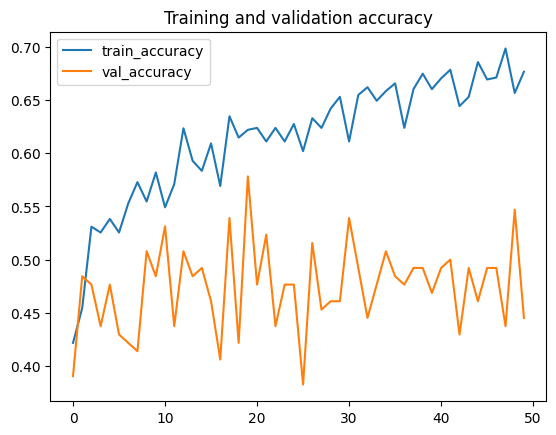

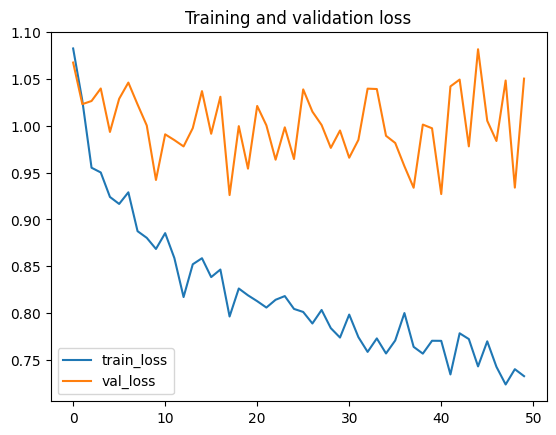

In [27]:
# Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()